In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, recall_score
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
# Lectura del Dataset
df = pd.read_csv("/content/drive/MyDrive/PFC1/Datasets/creditcard.csv")
df.shape
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [113]:
#Clases
# 0 -> No es fraude
# 1 -> Es fraude
#Conteo de 0s y 1s
np.bincount(df['Class'])

array([284315,    492])

## COMPOSICIÓN DEL DATASET

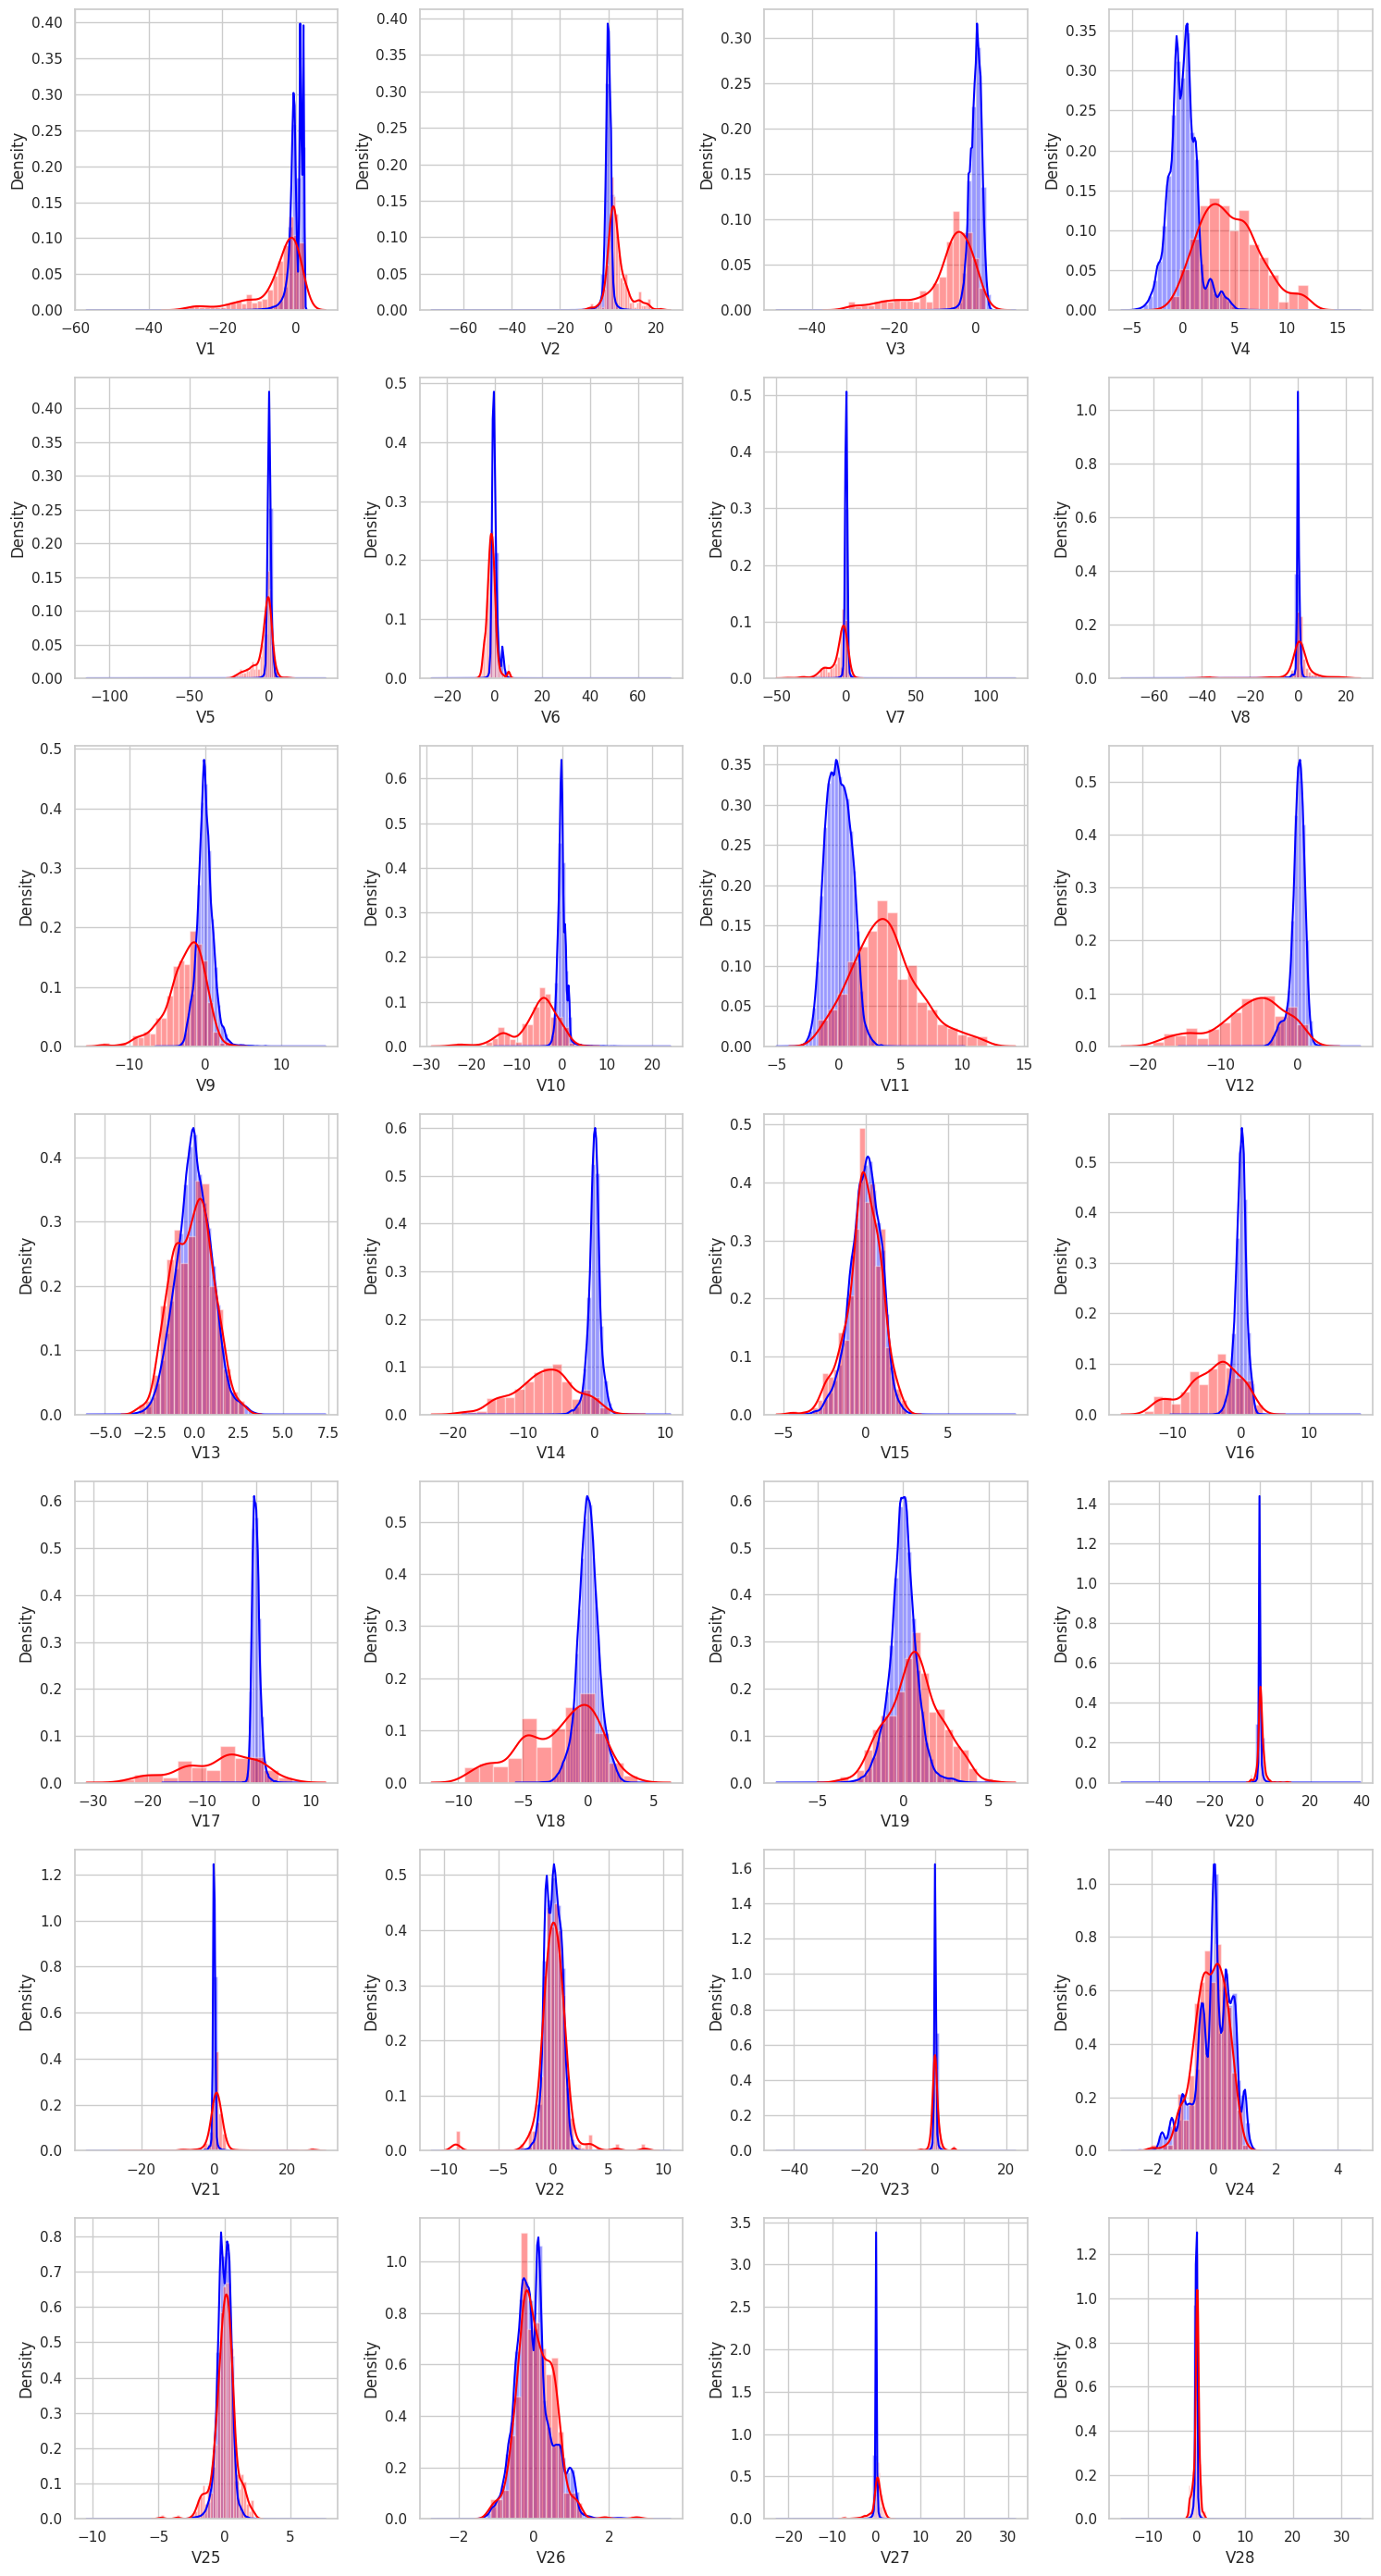

In [114]:
cols = df.columns.drop(['Time', 'Amount', 'Class'])

f, ax = plt.subplots(7, 4, figsize = (15, 28))
#Azul -> No fraude
#Rojo -> Fraude
for i, c in zip(ax.flatten(), cols):
    sns.distplot(df[c][df['Class'] == 0], color = 'blue', ax = i)
    sns.distplot(df[c][df['Class'] == 1], color = 'red', ax = i)
f.tight_layout()

### Relación *Nro. de transacciones/Tiempo*

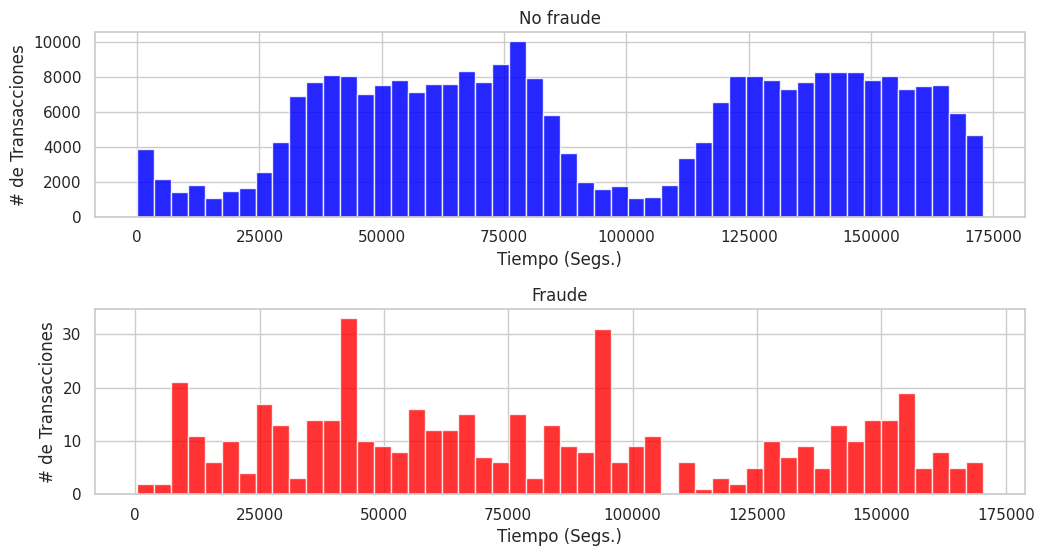

In [115]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5)
ax1.hist(df['Time'][df['Class'] == 0], bins = 50, color = 'blue' ,alpha = 0.85)

ax1.set_xlabel('Tiempo (Segs.)')
ax1.set_title('No fraude')
ax1.set_ylabel('# de Transacciones')


ax2.hist(df["Time"][df['Class'] == 1], bins = 50, color = 'red', alpha = 0.8)

ax2.set_xlabel('Tiempo (Segs.)')
ax2.set_ylabel("# de Transacciones")
ax2.set_title('Fraude')
plt.show()

### Relación *Monto/Nro. de transacciones*

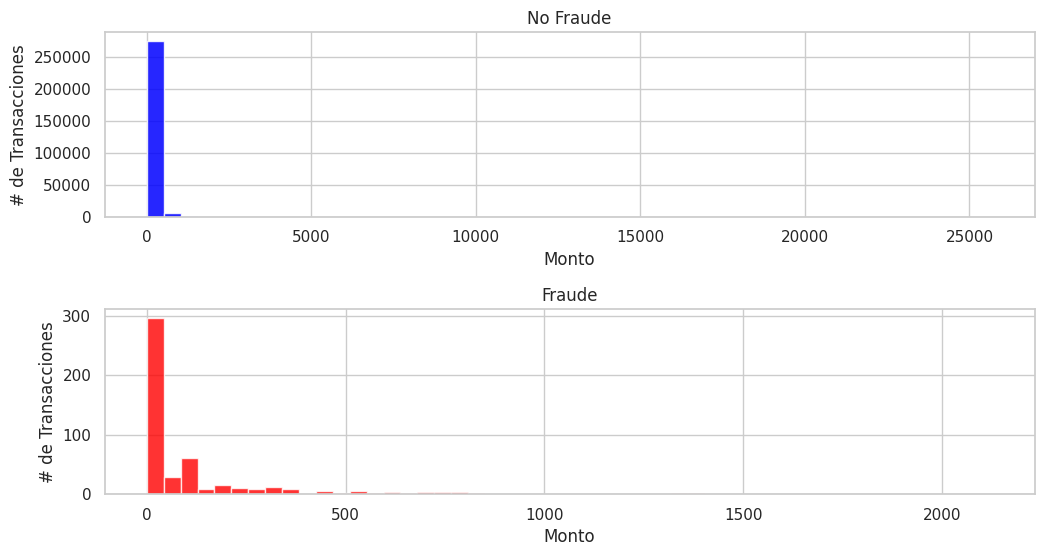

In [116]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5)
ax1.hist(df['Amount'][df['Class'] == 0], bins = 50, color = 'blue' ,alpha = 0.85)
ax1.set_xlabel('Monto')
ax1.set_title('No Fraude')
ax1.set_ylabel('# de Transacciones')


ax2.hist(df["Amount"][df['Class'] == 1], bins = 50, color = 'red', alpha = 0.8)
ax2.set_xlabel('Monto')
ax2.set_ylabel("# de Transacciones")
ax2.set_title('Fraude')
plt.show()

##EXTRACCIÓN DE CARACTERÍSTICAS

In [117]:
X = df.drop(['Time', 'Class'], axis = 1)
y = df['Class']
scaler = StandardScaler()
#Estandarización de "Monto"
X['Amount'] = scaler.fit_transform(X[['Amount']])
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [118]:
#Division de dataset en "train" y "valid" (20/80)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [119]:
#Aplicacion de SMOTE (Synthetic Minority Over-sampling Technique) para balancear un conjunto de datos
def oversampling(X_train, y_train):
# Oversampling the imbalanced dataset
    oversample = SMOTE(random_state = 42, sampling_strategy = 0.4)
    X, y = oversample.fit_resample(X_train, y_train)
    counter = Counter(y)
    print(counter)
    return X, y

In [120]:
X_train, y_train = oversampling(X_train, y_train)

Counter({0: 181961, 1: 72784})


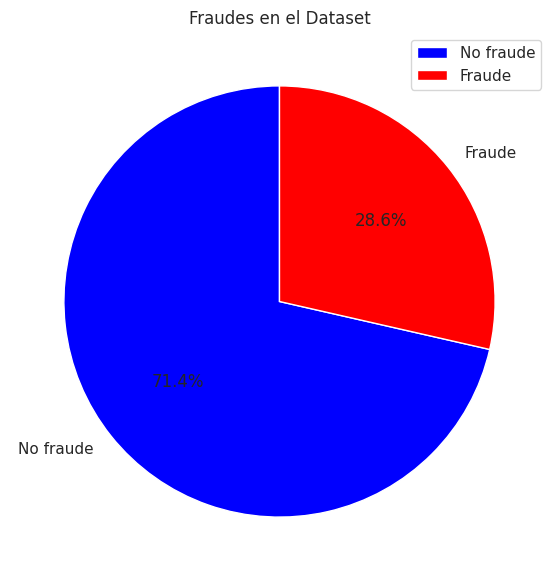

In [121]:
#Resultados del balanceo
sns.set(style="whitegrid")
labels = ['No fraude', 'Fraude']
sizes = y_train.value_counts()

colors = ["blue","red"]

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,)

plt.title('Fraudes en el Dataset')
plt.legend()
plt.show()

# Adición de "Ruido Gausiano"


In [122]:
def add_noise(X_train):
    mean = 0
    sigma = 0.1
    noise = np.random.normal(mean, sigma ,X_train.shape)
    X_train = X_train + noise
    return X_train
X_train_noised = add_noise(X_train)

In [123]:
#Formateo de la etiquetas
y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

In [124]:
#Conversion a one-hot encoding
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

#Modelo Autoencoder

In [125]:
epochs = 10
batch_size = 128
input_shape = X_train.shape[1] #Columnas - 29
lr = 1e-7

#Modelo autoencoder - Replicado
input_layer = keras.layers.Input(shape=(input_shape, ))
encoder = keras.layers.Dense(128, activation = "relu", activity_regularizer = keras.regularizers.l1(lr),
                             kernel_initializer = 'lecun_normal')(input_layer)
encoder = keras.layers.Dense(64, activation = "relu")(encoder)
encoder = keras.layers.Dense(32, activation = 'relu')(encoder)
decoder = keras.layers.Dense(32, activation = 'relu')(encoder)
decoder = keras.layers.Dense(64, activation = 'relu')(decoder)
decoder = keras.layers.Dense(128, activation = 'relu')(decoder)
decoder = keras.layers.Dense(29, activation = 'relu')(decoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)


autoencoder.compile(metrics = ['accuracy'],
                    loss = 'mean_squared_error',
                    optimizer = 'adam')


history = autoencoder.fit(X_train_noised, X_train_noised,
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (X_valid, X_valid),
                    verbose=1).history

Epoch 1/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6325 - loss: 7.2042 - val_accuracy: 0.7888 - val_loss: 0.6993
Epoch 2/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8320 - loss: 7.0204 - val_accuracy: 0.8113 - val_loss: 0.6894
Epoch 3/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8469 - loss: 7.0576 - val_accuracy: 0.8089 - val_loss: 0.6886
Epoch 4/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8581 - loss: 6.9817 - val_accuracy: 0.8260 - val_loss: 0.6865
Epoch 5/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8637 - loss: 6.9889 - val_accuracy: 0.8628 - val_loss: 0.6442
Epoch 6/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8853 - loss: 6.9959 - val_accuracy: 0.8457 - val_loss: 0.6476
Epoch 7/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8852 - loss: 6.9720 - val_accuracy: 0.8651 - val_loss: 0.6430
Epoch 8/10
1991/1991 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8936 - loss: 6.98

In [126]:
n_data = autoencoder.predict(X_train_noised)

7961/7961 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


#Modelo clasificador

In [127]:
epochs = 30
batch_size = 256
input_shape = X_train.shape[1] #Columnas - 29


input_layer = keras.layers.Input(shape = (input_shape, ))
layer_1 = keras.layers.Dense(128, activation = "relu",
                            kernel_initializer = 'lecun_normal')(input_layer)
layer_2 = keras.layers.Dense(64, activation = "relu", kernel_initializer = 'lecun_normal')(layer_1)
layer_3 = keras.layers.Dense(32, activation = 'relu', kernel_initializer = 'lecun_normal')(layer_2)
layer_4 = keras.layers.Dense(16, activation = 'relu', kernel_initializer = 'lecun_normal')(layer_3)
output_layer = keras.layers.Dense(2, activation = 'sigmoid')(layer_4)
fraud_dtr = keras.Model(inputs = input_layer, outputs = output_layer)

In [131]:
fraud_dtr.compile(metrics=['accuracy'],
                    loss='binary_crossentropy',
                    optimizer='sgd')

callback = keras.callbacks.ModelCheckpoint('Fraud_Detector_model.h5',
                                          save_best_only = True)

history = fraud_dtr.fit(n_data, y_train,
                    epochs = epochs,
                    batch_size  = 256,
                    validation_data = (X_valid, y_valid),
                    callbacks = [callback]).history

Epoch 1/30
982/996 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9096 - loss: 0.3742

996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9101 - loss: 0.3720 - val_accuracy: 0.9658 - val_loss: 0.1244
Epoch 2/30
988/996 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9634 - loss: 0.1206

996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9635 - loss: 0.1205 - val_accuracy: 0.9663 - val_loss: 0.1163
Epoch 3/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9669 - loss: 0.1058 - val_accuracy: 0.9628 - val_loss: 0.1224
Epoch 4/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9698 - loss: 0.0944 - val_accuracy: 0.9546 - val_loss: 0.1423
Epoch 5/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9727 - loss: 0.0857 - val_accuracy: 0.9393 - val_loss: 0.1896
Epoch 6/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9749 - loss: 0.0781 - val_accuracy: 0.9257 - val_loss: 0.2304
Epoch 7/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9773 - loss: 0.0698 - val_accuracy: 0.9130 - val_loss: 0.2774
Epoch 8/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9789 - loss: 0.0634 - val_accuracy: 0.9086 - val_loss: 0.3055
Epoch 9/30
996/996 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9799 - loss: 0.0584 - val_accuracy: 0.8863 - val

In [133]:
#Cargamos el modelo
model = keras.models.load_model('Fraud_Detector_model.h5')
model.evaluate(X_test, y_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9646 - loss: 0.1188


[0.11847687512636185, 0.9650468826293945]

In [134]:
predictions = model.predict(X_test)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


# Resultados de la clasificacion

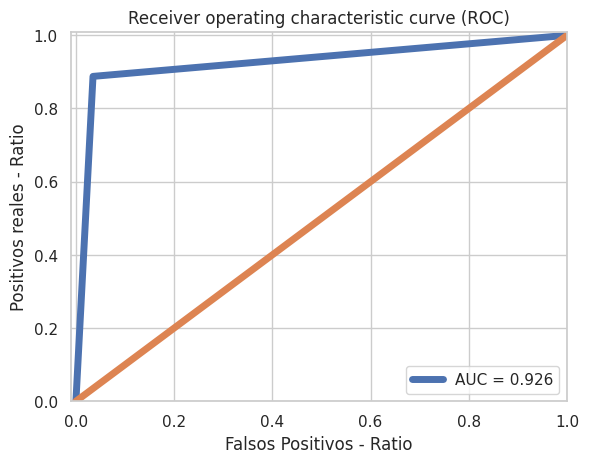

In [138]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test.argmax(axis = 1), predictions.argmax(axis = 1))
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 5, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth = 5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('Positivos reales - Ratio')
plt.xlabel('Falsos Positivos - Ratio')
plt.show()

In [139]:
print('Porcentaje de aciertos : ', recall_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) * 100, '%')

Porcentaje de aciertos :  88.77551020408163 %
